# Algorithmic trading agent built on Reinforcement Learning

This is an outline of a simple algorithmic trading agent built on reinforcement learning.

## Step 0: Imports

In [464]:
from itertools import accumulate
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions import Normal
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [14]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 1: Gather and prepare data

First we need to get the price series

In [73]:
def get_close_price(ticker, period='30d', interval='30m') -> pd.Series:
    """ Returns the closing price of a ticker in a period and interval """
    return yf.Ticker(ticker).history(period=period, interval=interval)['Close']

The price is normalized by dividing by the prevoius price and the rolling volatility

In [72]:
def get_normalized_price(close_price: pd.Series, volatility_period=10) -> pd.Series:
    """ Normalize price by dividing by the previous close price and 
        the rolling volatility """
    norm_price = (close_price[1:].values / close_price[:-1].values) - 1
    norm_price = np.insert(norm_price, 0, 0, axis=0)
    rolling_volatility = pd.Series(norm_price).rolling(volatility_period).std()
    norm_price = (norm_price/(rolling_volatility*np.sqrt(volatility_period))).fillna(0).values
    norm_price = np.clip(norm_price, -1, 1)
    norm_price = pd.Series(norm_price, index=close_price.index)
    return norm_price


The data is normalized on the training set in order to avoid lookahead bias

In [257]:
def normalize(series: np.ndarray, train_freq=0.5) -> np.ndarray: 
    """ Return the normalized series """
    series = series.reshape((len(series), 1))
    scaler = MinMaxScaler().fit(series[:int(len(series)*train_freq)])
    series = scaler.transform(series)
    series = series.flatten()
    return series


We use Relative Strength Index and Moving Average Convergence Divergence as features

In [262]:
def get_relative_strength_index(price: pd.Series, periods=14) -> pd.Series:
    """ Relative strength index from [0,100] to [-1, 1] """
    change = price.diff().fillna(0)
    gain = change.clip(lower=0)
    loss = -1 * change.clip(upper=0)
    ma_gain = gain.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    ma_loss = loss.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    rs = ma_gain / ma_loss
    rsi = 100 - (100/(1+rs))
    rsi = rsi.fillna(50)
    rsi = ((rsi/100) * 2) - 1
    return rsi

def moving_avg_conv_div(price: pd.Series, train_freq=0.5) -> np.ndarray:
    """ Standard MACD(12,26,9) normalized to [-1,1] """
    exp1 = price.ewm(span=12, adjust=False).mean()
    exp2 = price.ewm(span=26, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    h = macd_line - signal_line
    norm_h = (normalize(h.values, train_freq=train_freq) * 2) - 1
    return norm_h


Finally we concatenate the normalized price and the RSI to the state vector and also return the closing price

In [299]:
def get_states(ticker='AAPL', period='2y', interval='1h', train_freq=0.5):
    """ Returns the closing price with corresponding state vector """
    close_price = get_close_price(ticker, period, interval)
    #normalized_price = get_normalized_price(close_price)
    normalized_price = normalize(close_price.values, train_freq)
    rsi = get_relative_strength_index(close_price)
    macd = moving_avg_conv_div(close_price)
    states = np.concatenate(([normalized_price], [rsi], [macd]), axis=0).T
    return close_price, states


## Step 2: Define agent

See [Moody and Saffel](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=1a4999c918c6206cd9804c48f7dce1bac6ec5b4a) for explanation for the recursive mechanism used in the policy network. This mechanism allows the agent to consider transaction costs. 



In [74]:
class LinearDiscrete(nn.Module):
    def __init__(self, observation_space=8, action_space=1, out_layer_std=3e-3) -> None:
        super(LinearDiscrete, self).__init__()
        self.action_space = action_space
        self.fc_out = nn.Linear((observation_space+self.action_space), action_space)
        self.fc_out.weight.data.normal_(0, out_layer_std)

    def forward(self, x, prev_action=None) -> torch.Tensor:
        if prev_action is None: 
            prev_action = torch.Tensor(np.zeros((x.shape[0],self.action_space))).to(device)         
        x = torch.cat((x, prev_action.to(device)), dim=1).to(device) 
        x = self.fc_out(x)
        return x


The policy is defined as a normal probability density over a real-valued scalar action
$
\pi_{\theta, \epsilon} ({a}| \mathbf{s}) = \frac{1}{\epsilon \sqrt{2\pi}} e^{\left(-\frac{\left({a} - \mu_\theta(\mathbf{s}) \right)^2}{2 \epsilon^2}\right)}
$

Where $\mu_\theta(\mathbf{s})$ is the function approximator defined above and $\epsilon \geq 0$ is a decaying exploration rate
$
\epsilon \leftarrow \max{(\lambda_\epsilon \epsilon, \epsilon_{min})}
$

We define the stochastic policy as

In [75]:
def act_policy(net: nn.Module, state: np.ndarray, prev_action=None, epsilon=0):
    """ Returns a sampled action on [-1, 1], the log probability of choosing that action, and the hidden state """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    mean = net.forward(state, prev_action).to(device)
    mean = torch.tanh(mean)
    std = max(epsilon, 1e-8)
    dist = Normal(mean, std) 
    action = dist.sample() 
    return torch.clamp(action, -1, 1).cpu().numpy().flatten(), dist.log_prob(action).to(device)


## Step 3: Define the environment

First we define some helper-functions for calculating the reward function. 
These functions will help calculate the net multiplicative logarithmic returns
$
{r}^{net}_t = \log{\left(  \frac{p_t}{p_{t-1}} \right)} {a}_{t-1}  - \lambda_c || {a}_{t-1} - {a}'_{t-1} || 
$
where $\lambda_c \in [0,1]$ is the transaction cost fraction and 
$
{a}'_t = \frac{a_{t-1} \frac{p_t}{p_{t-1}}}{a_{t-1} y_t + 1}
$

In [76]:
def asset_return(position_new, position_old, price_new, price_old, transaction_fraction=0.0002) -> np.ndarray:
    """ R_t = a_{t-1} * log(p_t / p_{t-1}) - transaction costs """
    gross_return = position_new * np.log((price_new + float(np.finfo(np.float32).eps))/(price_old + float(np.finfo(np.float32).eps)))
    net_return = gross_return - transaction_costs(position_new, position_old, price_new, price_old, transaction_fraction)
    return net_return

def transaction_costs(position_new, position_old, price_new, price_old, transaction_fraction=0.0002):
    """ Transaction costs for single instrument trading """
    price_changes = ((price_new + float(np.finfo(np.float32).eps)) /(price_old + float(np.finfo(np.float32).eps))) 
    weight_as_result_of_price_change = (position_old * price_changes) / ((position_old * (price_changes-1)) + 1)
    required_rebalance = np.abs(position_new - weight_as_result_of_price_change)
    t_costs = transaction_fraction * required_rebalance
    return t_costs

Then we define the environment. The final reward function uses the variance over returns
$
\sigma^2(r^{net}_i | i=t-L+1,...,t)=\sigma^2_{L}(r^{net}_t)
$
(where $L=60$) as a risk term in the final reward function
$
r_t = {r}^{net}_t - \lambda_\sigma \sigma^2_{L}({r}^{net}_t)
$
where $\lambda_\sigma \geq 0$ is a risk sensitivity term. 

In [431]:
class TradeEnvironment():

    def __init__(self, states, prices,transaction_fraction=0.002, num_prev_observations=10, std_lookback=60, std_factor=0.1) -> None:
        self.prices = prices
        self.transaction_fraction = transaction_fraction
        self.states = states
        self.current_index = 0
        self.position = np.zeros((1,))
        self.returns = np.zeros((len(prices),))
        self.std_factor = std_factor
        self.std_lookback = std_lookback
        self.observations = np.array([self.states[self.current_index] for _ in range(num_prev_observations)]) 

    def reset(self) -> np.ndarray:
        """ Reset environment to start and return initial state """
        self.current_index = 0 
        self.position.fill(0)
        self.observations = np.array([self.states[self.current_index] for _ in range(len(self.observations))]) 
        return self.state()

    def state(self) -> np.ndarray:
        """ Returns the state vector """
        return self.observations.flatten()

    def reward_function(self, action) -> float: 
        """ Returns reward signal based on the environments chosen reward function. """
        ret = asset_return(position_new=action, 
                        position_old=self.position, 
                        price_new=self.prices[self.current_index],
                        price_old=self.prices[self.current_index-1],
                        transaction_fraction=self.transaction_fraction)
        self.returns[self.current_index-1] = ret  # Add returns to array of old returns
        risk_punishment = np.std(self.returns[max(0, (self.current_index-self.std_lookback)):self.current_index])
        return np.sum(ret) - (self.std_factor * risk_punishment)

    def step(self, action):
        """
        Args:
            action (np.ndarray):        the actors action. 
        Returns:
            new state (np.ndarray):     the new observed state. 
            reward (float):             reward signal. 
            termination status (bool):  flag indicating if the state is terminal. 
            info:                       -
        """
        self.current_index += 1 
        assert all(action <= 1.) and all(action >= -1.)
        if self.current_index >= len(self.states): 
            return self.state(), 0, True, {} 
        reward = self.reward_function(action)
        self.position = action
        self.observations = np.concatenate((self.observations[1:], [self.states[self.current_index]]), axis=0) # FIFO state vector update
        return self.state(), reward, False, {}


## Step 4: Define RL algo

First we define the optimization function, which consists of re-setting the gradients of the network, performing a backwards pass and an optimization step using the Adam optimizer. 

In [78]:
def optimize(optimizer: optim.Adam, loss: torch.Tensor) -> None: 
    """ Set gradients to zero, backpropagate loss, optimization step """
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

The we define the policy loss function, which is defined as
The gradient of the performance measure $J$ is calculated using the policy gradient theorem on minibatches $[t_s, t_e]$ when following the policy $\pi_{\theta, \epsilon}$
$
\nabla_\theta J(\pi_{\theta, \epsilon})_{[t_{s},t_{e}]} = \mathbb{E}_{\pi_{\theta, \epsilon}} \left[ \sum_{t=t_s + 1}^{t_e} r_t \nabla_\theta \log \pi_{\theta, \epsilon}(a_t | s_t) \right]
$

In [420]:
def get_policy_loss(rewards: list, log_probs: list) -> torch.Tensor:
    """ Return policy loss """
    r = torch.FloatTensor(rewards).to(device)
    log_probs = torch.stack(log_probs).squeeze().to(device)
    policy_loss = torch.mul(log_probs, r).mul(-1).sum().to(device)
    return policy_loss

The RL algorithm is based on the REINFORCE algorithm

In [383]:
def reinforce(policy_network: torch.nn.Module, env, act, alpha=1e-3, 
              discount_factor=0, weight_decay=1e-5, exploration_rate=1, 
              exploration_decay=0.9, exploration_min=0, num_episodes=1000, 
              train=True):
    """
    REINFORCE/Monte Carlo policy gradient algorithm

    Args: 
        policy_network (nn.Module): the policy network. 
        env: the reinforcement learning environment which takes an action and 
             returns the new state, reward, and termination flag. 
        act: a function that uses the policy network to generate some output 
             based on the state, and then transforms that output to an action.
        alpha (float): the learning rate on [0,1] for the policy network. 
        discount_factor (float): number on [0,1] discounting future rewards.
        weight_decay (float): regularization parameter for the policy network.
        exploration_rate (number): the intial exploration rate.
        exploration_decay (number): the exploration decay rate.
        exploration_min (number): the minimum exploration rate. 
        num_episodes (int): the number of episodes to be performed. 
        train (bool): wheteher the policy network is in train or evaluation mode. 
    Returns:
        reward_history (np.ndarray): the sum of rewards for all completed episodes.
        action_history (np.ndarray): the array of actions of all completed episodes.
    """
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=alpha, 
                           weight_decay=weight_decay)
    reward_history, action_history = [], []

    if not train:
        exploration_min, exploration_rate = 0, 0
        policy_network.eval()
    else:
        policy_network.train()

    for n in range(num_episodes):
        state = env.reset() #S_0
        prev_action = None
        done = False
        rewards, actions, log_probs = [], [], []

        for _ in range(np.iinfo(np.int32).max):
            action, log_prob = act(policy_network, state, prev_action, exploration_rate) #A_{t-1}
            state, reward, done, _ = env.step(action) # S_t, R_t 
            prev_action = torch.Tensor(action).unsqueeze(0)

            if done:
                break

            actions.append(action)
            rewards.append(reward) 
            log_probs.append(log_prob)
        
        if train and rewards != []:
            weighted_rewards = list(accumulate(reversed(rewards), lambda x,y: x*discount_factor + y))[::-1]
            policy_loss = get_policy_loss(weighted_rewards, log_probs)
            optimize(optimizer, policy_loss)

        reward_history.append(sum(rewards))
        action_history.append(np.array(actions))
        exploration_rate = max(exploration_rate*exploration_decay, exploration_min)

    return np.array(reward_history), np.array(action_history)

## Step 5: Run the training loop

First, get the closing prices and corresponding states

In [457]:
price, states = get_states()
num_features = states.shape[1]
num_prev_obs = 3
total_num_features = num_features * num_prev_obs

Then we split the states and prices into train and test sets, and creates a train and test environment.

In [458]:
train_split = 1/2
states_train = states[:int(states.shape[0]*train_split)]
states_test = states[-int(states.shape[0]*(1-train_split)):]

price_train = price[:int(len(price)*train_split)]
price_test = price[-int(len(price)*(1-train_split)):]

std_factor=0.1
train_env = TradeEnvironment(states=states_train, prices=price_train, num_prev_observations=num_prev_obs, std_factor=std_factor)
test_env = TradeEnvironment(states=states_test, prices=price_test, num_prev_observations=num_prev_obs, std_factor=std_factor)

Then we define the policy network, and train it on the training environment using the RL algorithm. 

In [459]:
policy = LinearDiscrete(observation_space=total_num_features, action_space=1).to(device)
scores, actions = reinforce(policy, 
                            train_env, 
                            act=act_policy, 
                            alpha=1e-2, 
                            num_episodes=50)

Display training reward over epochs

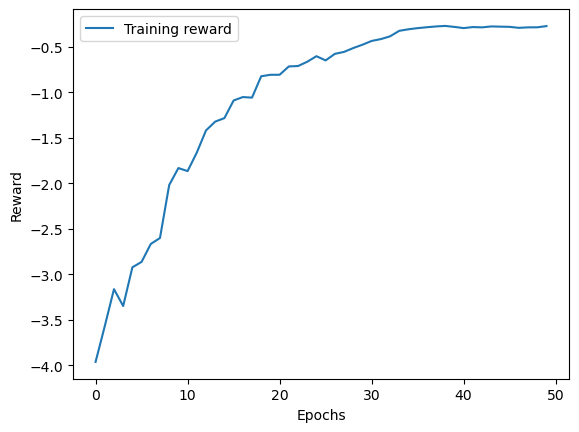

In [460]:
plt.plot(scores, label='Training reward')
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.legend()
plt.show()

## Step 6: Final testing

Run RL loop once on test environment and get actions 

In [461]:
scores, actions = reinforce(policy, 
                            test_env, 
                            act=act_policy, 
                            alpha=1e-2, 
                            early_stopping=False,
                            num_episodes=1)

Calculate linear cumualtive returns from the actions generated by the agent on the test set

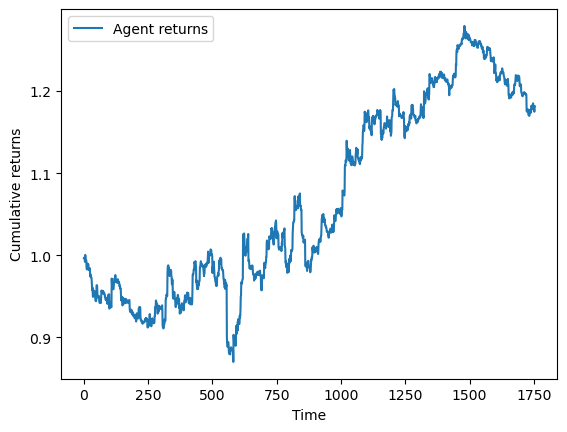

In [462]:
plt.plot(np.cumprod(actions[0].flatten() * price_test.pct_change().values[1:] + 1), label='Agent returns')
plt.xlabel('Time')
plt.ylabel('Cumulative returns')
plt.legend()
plt.show()

Display agents actions on test set

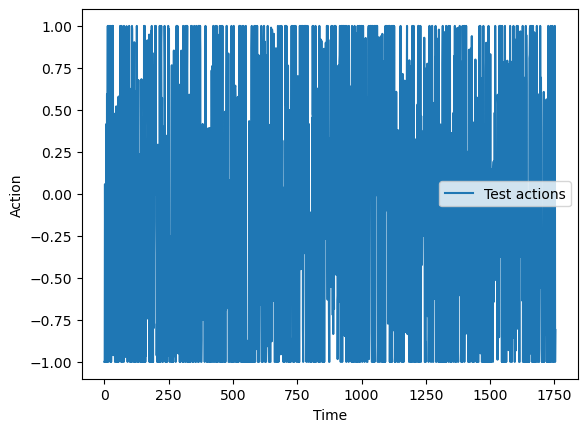

In [463]:
plt.plot(actions[-1], label='Test actions')
plt.xlabel('Time')
plt.ylabel('Action')
plt.legend()
plt.show()